# CMSC 641- Mini Tutorial:  Analyzing a New Jersey Nursing Data Set.  Valerie Nelson, Fall 2018

### In this tutorial, we will go through the process for doing some analysis of an Excel file downloaded during the summer of 2018 from the New Jersey Division of Consumer Affairs (https://www.njconsumeraffairs.gov/requestlist/Pages/default.aspx) containing data on the licensure of Registered Nurses in the state at that time.  We will discuss select topics on the following things:
- Data Cleaning (practice)
- Exploratory Data Analysis (practice)
- Mapping with Folium (practice)
- Presenting Results & Data Coarsening (comments)

### In the process, we will also discuss some observations resulting from performing these tasks and what insights can be gained from them.  In particular, we will consider the geographical distribution of Registered Nurses (RN) across the state of New Jersey, according to the data, and its impact on the availability of medical support at a given time, such as during an unexpected state of emergency. 

#### The author would like to thank Kimberly Hampton, RN/MBA, for providing the data and information on nurse licensing, and for considering a new perspective on how to analyze this type of data.   Special thanks also goes to Jason C. who provided lots of technical support and assistance with the folium mapping requirements for this project.

### Step 1:  Looking at the Data

The file we were given is an Excel spreadsheet.  In order to perform analysis on the data, we would like to use Python and its different packages that allow us to perform various tasks. In order to do this, we will read the data into a Pandas dataframe to view it and determine what types of information we have.  We will do this using the code below.

In [1]:
#Import needed python packages

import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
import datetime
import random
import calendar

%matplotlib inline

In [2]:
#Read in data file into a dataframe and display the data shape and first 5 rows (the "head")
file_name = 'NJ_Nursing_licenses-Summer2018.xlsx'

df = pd.read_excel(file_name)
print("df shape is", df.shape)
df.head()

df shape is (127495, 20)


,full_name,first_name,middle_name,last_name,name_suffix,gender,license_no,issue_date,expiration_date,addr_line_1,addr_line_2,addr_city,addr_state,addr_zipcode,addr_county,addr_phone,addr_fax,addr_email,license_status_name,Unnamed: 19
0,A BAUERSACHS,A,NaN,BAUERSACHS,NaN,F,26NR03881300,1/1/1888,2018-05-31,4 TIGERS CT,NaN,MERCERVILLE,NJ,86191128,Mercer,6095869696,NaN,annbauersachs123@aol.com,Active,NaN
1,A BETRUS,A,NaN,BETRUS,NaN,F,26NR03410300,1/1/1888,2020-05-31,452 ST GILES COURT,NaN,SOMERSET,NJ,8873,Somerset,7327640438,NaN,acobane1020@gmail.com,Active,NaN
2,A C HABERMAN,A,C,HABERMAN,NaN,F,26NR02374200,1/1/1888,2020-05-31,122 JOSEPH ST,NaN,East Bunswick,NJ,8816,Middlesex,NaN,NaN,NaN,Active,NaN
3,A CHANDA,A,NaN,CHANDA,NaN,F,26NR03652100,1/1/1888,2018-05-31,61 FOOTHILLS DRIVE,NaN,South River,NJ,88822506,Middlesex,NaN,NaN,tchanda@comcast.net,Active,NaN
4,A DI SCALA,A,NaN,DI SCALA,NaN,F,26NR03060900,1/1/1888,2020-05-31,686 COOPER AVE,NaN,ORADELL,NJ,76492310,Bergen,2014385683,2014385786,adiscala1@optonline.net,Active,NaN


The shape of the dataframe tells us that we have over 127K rows with 20 columns, or different "features" associated with each row.  From inspection of the column names and first 5 rows displayed above, it appears that each row consists of some very specific information of different data types, for an individual Registered Nurse.  We can already see that some of the information is sensitive (full name, home address, phone numbers, etc.), there are missing values in some columns (e.g. "NaN" for "Not a Number"), and that there are incomplete values (eg. zip codes that are too short).  We also note that some values may have been imputed, or provided by an analyst to replace a missing or invalid value.  We infer this from the presence of date "1/1/1888' as a license issue date, which is repeated in other rows but highly unlikely based on the expiration dates.  

We have already made several observations by only viewing the first 5 rows of data, but there is so much more to review!  However, it is not practical to review each row in the data set to determine where there is information that needs to be adjusted.  Fortunately, we can use the "info" method for dataframes to give us a summary of information about the columns and their data types.  If we only want a list of columns, we can use the 'columns' attribute of the dataframe.  We call both of these methods below.

In [3]:
#List the column names
df.columns

Index(['full_name', 'first_name', 'middle_name', 'last_name', 'name_suffix',
       'gender', 'license_no', 'issue_date', 'expiration_date', 'addr_line_1',
       'addr_line_2', 'addr_city', 'addr_state', 'addr_zipcode', 'addr_county',
       'addr_phone', 'addr_fax', 'addr_email', 'license_status_name',
       'Unnamed: 19'],
      dtype='object')

In [4]:
#Give the column names, data types, and number of non-null values in each
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127495 entries, 0 to 127494
Data columns (total 20 columns):
full_name              127495 non-null object
first_name             127495 non-null object
middle_name            85262 non-null object
last_name              127494 non-null object
name_suffix            347 non-null object
gender                 127459 non-null object
license_no             127495 non-null object
issue_date             127462 non-null object
expiration_date        127495 non-null datetime64[ns]
addr_line_1            127111 non-null object
addr_line_2            8105 non-null object
addr_city              127430 non-null object
addr_state             127435 non-null object
addr_zipcode           127430 non-null object
addr_county            127392 non-null object
addr_phone             114235 non-null object
addr_fax               12526 non-null object
addr_email             104793 non-null object
license_status_name    127494 non-null object
Unnamed: 19   

The above summary tells us that there are exactly 127,495 rows, the column names and how many non-null values there are in each column, and what the column data types are.  The information indicates that there are many columns with null values since the number of non-null objects for a column is not always equal to 127,495 = the number of rows.  Additionally, values in the 'expiration_date' are given as datetime objects, although this is not the case for the 'issue_date' column where we already observed values of '1/1/1888'.  The other columns are most likely of string type, even when the values are numeric, but we can verify this as needed. The next step is to decide what values we need to "clean" in order to do our analysis.  

### Step 2:  Preliminary EDA and Data Cleaning

In order to determine how to proceed without performing unnecessary tasks, we need to consider our ultimate goal, which will help us identify which data we will need and what we need to do with that data.  In this tutorial, we are interested in investigating the geographical distribution and the availability of RNs across NJ.  Therefore, many of the columns with null or incomplete values will not play a role in our analysis, and therefore, we do not need to spend time cleaning these columns.  Some of the columns we may want to use for our analysis for the purpose of this tutorial include the following:
- full_name
- gender
- license_no
- issue_date
- expiration_date
- addr_city
- addr_state
- addr_county  

We will ignore the other columns for now but discuss how we'd handle them during a later discussion. For now, we will consider the columns we intend to use for our analysis and look at them individually to see how we can "clean" them as appropriate.  Before we make any changes though, we will make a copy of the dataframe which we will modify so we still have the original for reference purposes.

In [5]:
#Make a copy of the dataframe to be used for modifications
df_clean = df.copy()

Before we get started, let's check for duplicate records and delete them if there are any.

In [6]:
#Drop duplicated rows and rows
print("Length of original dataframe is", len(df_clean))

df_clean.drop_duplicates(keep='first', inplace=True)
print("Length of clean dataframe is", len(df_clean))

Length of original dataframe is 127495
Length of clean dataframe is 127495


Looks like there are no duplicate records, so let's press on!  

#### Full Name, Gender, and License Number Columns

Let us now consider the information we obtained about our dataframe about the first 3 columns in our list of interest:
- full_name
- gender
- license_no

For each column, we have an idea of what to expect (or not to expect).  However, it is a good idea to check that the values that have been entered are valid. Based on the type of data we expect, we will check some different things to gain confidence about the validity of the values.  Some things to check include the list of values that appear in a column, their distribution of those values, and the data type. 

For *full_name*, we expect there to be string-like values here, and these could be anything.  Here, we are told that there are no null values and will assume we have valid values for this column.  However, there are some null values in the 'gender' column, but we do know in general what types of values to expect for this field.  We will use the 'unique' method to list the different types of values found in this column.

In [7]:
#Check values given in 'gender' column
df_clean.gender.unique()

array(['F', 'M', nan], dtype=object)

So let's look at our distribution of values and view only the rows where the *gender* field is null.  We want to make sure there is nothing strange occurring with these rows that would automatically cause nulls rather than the values just being unavailable.  

In [8]:
#Check 'gender' distribution and view the rows with null gender values
print(df_clean.gender.value_counts(dropna=False))
df_clean[df_clean['gender'].isnull()]

F      116055
M       11404
NaN        36
Name: gender, dtype: int64


,full_name,first_name,middle_name,last_name,name_suffix,gender,license_no,issue_date,expiration_date,addr_line_1,addr_line_2,addr_city,addr_state,addr_zipcode,addr_county,addr_phone,addr_fax,addr_email,license_status_name,Unnamed: 19
5788,MARGIE CORANEZ OWEN,Margie,Coranez,Owen,NaN,NaN,26NR19589600,2017-09-18 00:00:00,2019-05-31,22 Hanover Avenue,NaN,Dallas,GA,30157,Paulding,4784565250,NaN,margie.owen@anthem.com,Active,NaN
9804,TARESSA L. POST,Taressa,L.,Post,NaN,NaN,26NR19189500,2017-03-08 00:00:00,2019-05-31,144 Marilyn Dr,NaN,Brick,NJ,8723,Ocean,7325756577,NaN,drtaressa4@outlook.com,Active,NaN
55791,TERESA MICHELLE TAYLOR-KING,Teresa,Michelle,Taylor-King,NaN,NaN,26NR13064700,2007-05-01 00:00:00,2019-05-31,8 Allerton Rd,NaN,Lebanon,NJ,8833,Hunterdon,4058184027,NaN,VALLEY2ME2@GMAIL.COM,Active,NaN
72059,LYNETTE MORETTI,LYNETTE,NaN,MORETTI,NaN,NaN,26NR10204200,2001-04-02 00:00:00,2019-05-31,3033 LAKESIDE DRIVE,NaN,Harveys Lake,PA,18618,Luzerne,6105541405,NaN,LMORETTI279@COMCAST.NET,Active,NaN
73230,JOYCE TOLENTINO VALLEJO,JOYCE,TOLENTINO,VALLEJO,NaN,NaN,26NR10040400,2000-07-27 00:00:00,2018-05-31,425 TURNBRIDGE DR,NaN,Galloway,NJ,8205,Atlantic,6096525809,NaN,JTVALLEJO@YAHOO.COM,Active,NaN
73598,PATRICIA MARY SULLIVAN,PATRICIA,MARY,SULLIVAN,NaN,NaN,26NR10029900,2000-07-05 00:00:00,2018-05-31,7B DANIEL WELSTER DRIVE,NaN,Monroe Township,NJ,8831,Middlesex,6462343840,NaN,NaN,Active,NaN
73783,KELLY ANNE ANDERSON,KELLY,ANNE,ANDERSON,NaN,NaN,26NR10008300,2000-06-07 00:00:00,2020-05-31,3 TALL TREE LANE,NaN,Langhorne,PA,19047,Bucks,2672377420,NaN,KELJOSSAM@HOTMAIL.COM,Active,NaN
73929,JULIE COLITTO,JULIE,NaN,COLITTO,NaN,NaN,26NR09974500,2000-04-05 00:00:00,2020-05-31,31 TRUESDALE DRIVE,NaN,Croton on Hudson,NY,10520,Westchester,NaN,NaN,NaN,Active,NaN
74579,JACQUELINE GLICKMAN IOLI,Jacqueline,Glickman,Ioli,NaN,NaN,26NR09884300,1999-11-03 00:00:00,2019-05-31,409 Cheltena Avenue,NaN,Jenkintown,PA,19046,Montgomery,2156055906,NaN,jgioli@yahoo.com,Active,NaN
74743,JOYCE ANN SHARP,JOYCE,ANN,SHARP,NaN,NaN,26NR09858400,1999-09-22 00:00:00,2019-05-31,6803 Montecito Lane,NaN,Louisville,KY,40291,Jefferson,5025945254,NaN,JSHARP7@HUMANA.COM,Active,NaN


From inspection, the rows with null 'gender' values appear to be valid rows and nothing we need to delete from our data collection.  At this point, we have a few options.  We can either (1) make an educated guess at the gender for each of these rows using the generally associated gender with the names, (2) replace the null with the value that most frequently occurs (the mode, which in this case, is 'F'), (3) create a third value to replace the null, such as "Other" or "Unknown", or (4) leave the values as null.  Since it will be interesting to view the gender distributions later while doing more EDA, let's choose option 3 and replace the nulls with "U" for "Unknown". 

In [9]:
#Replace nulls in 'gender' column with "U" for "Unknown"

df_clean['gender'] = df.gender.apply(lambda x: x if not pd.isnull(x) else 'U')
df_clean.gender.value_counts()

F    116055
M     11404
U        36
Name: gender, dtype: int64

Now let's look at the 'license_no' column.  If we have 127,495 rows representing 127,495 different people then we expect to have 127,495 different values.  Additionally, we see that the values start with the same three chracters and have the same structure, which we can check.  Let's check the number of unique values in this column and see if any have values with the first three characters varying from '26N' in the beginning or '00' at the end.  We will actually use a regular expression to ensure that each value conforms to the specified format with numeric and alphabetic characters found in the appropriate positions.  This allows us to identify possible typos that may have occurred when the data was initially entered. 

In [10]:
#Check # unique values in 'license_no' column and check for values with invalid first 3 characters
unique_values = df_clean.license_no.unique()
print(len(unique_values))

#Display any rows with 'license_no' values not conforming to the appropriate format
#An example value is '26NR04802100'
df_clean[~df_clean['license_no'].str.match('^26N[A-Z]{1}[0-9]{6}00$')]

127495


,full_name,first_name,middle_name,last_name,name_suffix,gender,license_no,issue_date,expiration_date,addr_line_1,addr_line_2,addr_city,addr_state,addr_zipcode,addr_county,addr_phone,addr_fax,addr_email,license_status_name,Unnamed: 19


So we found no rows that do not conform to the appropriate format, so we will assume that the values are valid for now.

#### Date Columns

We will now consider the two date columns- 'issue_date' and 'expiration_date'.  The first thing we notice is that 'issue_date' has some null values.  Further, the expiration dates are datetime objects but not the issue dates.  In order to take advantage of the properties of datetime objects for later manipulation, we want to convert the 'issue_date' values to datetime objects.  We also want to handle the strange issue dates such as '1/1/1888', '1/1/1901', or those with years well before the year 1950 (randomly chosen as a sensible date), suggesting that either these dates are unknown, in error, or that some very senior people are still licensed as RNs and have been practicting for at least 68 years, as of 2018! Let's start with viewing the rows with null values.

In [11]:
#Display rows with null 'issue_date' values
temp_df = df_clean[df_clean['issue_date'].isnull()]
print(len(temp_df))
temp_df

33


,full_name,first_name,middle_name,last_name,name_suffix,gender,license_no,issue_date,expiration_date,addr_line_1,addr_line_2,addr_city,addr_state,addr_zipcode,addr_county,addr_phone,addr_fax,addr_email,license_status_name,Unnamed: 19
127462,C DASHEVSKY,C,NaN,DASHEVSKY,NaN,F,26NR03841000,NaN,2018-05-31,33 Pilgrim Ave,NaN,Tinton Falls,NJ,7753,Monmouth,7329221046,NaN,NaN,Active,NaN
127463,CAROLYN KOHLHEPP,CAROLYN,NaN,KOHLHEPP,NaN,F,26NR03599000,NaN,2020-05-31,600 South Woods Road,NaN,Hillsborough,NJ,8844,Somerset,9088746252,9736216548,carolyn@njfpl.org,Active,NaN
127464,DEBORAH N EINSEL,DEBORAH,N,EINSEL,NaN,F,26NO05360400,NaN,2019-05-31,1562 APPLEWOOD CIRCLE,NaN,YARDLEY,PA,19067,Bucks,2153692814,NaN,deborahbish@gmail.com,Active,NaN
127465,DEBRA V WOODRUFF,DEBRA,V,WOODRUFF,NaN,F,26NO05254600,NaN,2020-05-31,111 St. George's Drive,NaN,Galloway,NJ,8205,Atlantic,7196604123,NaN,debbie_nurse3@yahoo.com,Active,NaN
127466,DIANE GARZIO,Diane,NaN,Garzio,NaN,F,26NO05431400,NaN,2019-05-31,5 Sandy Lane,NaN,Trenton,NJ,8610,Mercer,6099843922,NaN,diana.garzio@doh.nj.gov,Active,NaN
127467,EILEEN STEELE,Eileen,NaN,Steele,NaN,F,26NO05146700,NaN,2019-05-31,514 Brighton Avenue,NaN,Spring Lake,NJ,7762,Monmouth,7322397135,NaN,steeleeileen@gmail.com,Active,NaN
127468,EVELYN COYLE,Evelyn,NaN,Coyle,NaN,F,26NO04518100,NaN,2019-05-31,6 Iris Court,NaN,Little Egg Harbor,NJ,8087,Ocean,6092966337,NaN,NaN,Active,NaN
127469,FLORENCE M MAY,FLORENCE,M,MAY,NaN,F,26NR03873200,NaN,2018-05-31,10 MUSKET LANE,NaN,PENNSVILLE,NJ,80703421,Salem,8566785051,NaN,NaN,Active,NaN
127470,G WILLIAMS,G,NaN,WILLIAMS,NaN,F,26NR02469800,NaN,2020-05-31,308 Washington Avenue,NaN,Laurel Springs,NJ,80212050,Camden,8567838257,NaN,NaN,Active,NaN
127471,GERTRUDE ENTWISTLE,Gertrude,NaN,Entwistle,NaN,F,26NR01663900,NaN,2020-05-31,1230 Stonewall Jackson Dr,NaN,Dandridge,TN,37725,Jefferson,8653978669,NaN,trudy@medfordstation.com,Active,NaN


From inspection, it looks like there is nothing strange about these rows.  A question that should arise, however, is why these rows have null values for the license issue date but others have the value of January 1, 1888 or contain the year 1901, or some other very early date which we assume was put there when an issue date was not provided for one reason or another; maybe because the issue date was prior to a time when this information was collected and compiled.  So what's the difference here?  Without verifying with the people who entered the info, we may never know.  However, we can fill in these values by making some assumptions but providing some type of notation to indicate how the values were chosen.

In the code below, we will do a few things by creating two new columns to "standardize" the dates for later analysis which will do the following: 

- indicate when the issue date value was before January 1, 1950 or null
- replace all null dates and those before January 1, 1950 with this date for standardization
- convert the dates to datetime objects

In [12]:
#Create new column as 'issue_date' indicator before modifying values
#Note-Some 'NaN' values were cast to floats; code accounts for this

def create_Indicator_Col(data):
    if data == '1/1/1888':
        return 'Standardized'
    elif isinstance(data, datetime.date):
        if data.year < 1950:
            return 'Standardized'
        else:
            return 'Actual'
    elif isinstance(data, float) or data == np.nan:
        return 'Unknown'
    
indicator_col = df_clean['issue_date'].apply(create_Indicator_Col)
df_clean.insert(8, 'issue_date_notes', indicator_col) #Positions column at index 8
df_clean.head()

,full_name,first_name,middle_name,last_name,name_suffix,gender,license_no,issue_date,issue_date_notes,expiration_date,...,addr_line_2,addr_city,addr_state,addr_zipcode,addr_county,addr_phone,addr_fax,addr_email,license_status_name,Unnamed: 19
0,A BAUERSACHS,A,NaN,BAUERSACHS,NaN,F,26NR03881300,1/1/1888,Standardized,2018-05-31,...,NaN,MERCERVILLE,NJ,86191128,Mercer,6095869696,NaN,annbauersachs123@aol.com,Active,NaN
1,A BETRUS,A,NaN,BETRUS,NaN,F,26NR03410300,1/1/1888,Standardized,2020-05-31,...,NaN,SOMERSET,NJ,8873,Somerset,7327640438,NaN,acobane1020@gmail.com,Active,NaN
2,A C HABERMAN,A,C,HABERMAN,NaN,F,26NR02374200,1/1/1888,Standardized,2020-05-31,...,NaN,East Bunswick,NJ,8816,Middlesex,NaN,NaN,NaN,Active,NaN
3,A CHANDA,A,NaN,CHANDA,NaN,F,26NR03652100,1/1/1888,Standardized,2018-05-31,...,NaN,South River,NJ,88822506,Middlesex,NaN,NaN,tchanda@comcast.net,Active,NaN
4,A DI SCALA,A,NaN,DI SCALA,NaN,F,26NR03060900,1/1/1888,Standardized,2020-05-31,...,NaN,ORADELL,NJ,76492310,Bergen,2014385683,2014385786,adiscala1@optonline.net,Active,NaN


In [13]:
df_clean.tail()

,full_name,first_name,middle_name,last_name,name_suffix,gender,license_no,issue_date,issue_date_notes,expiration_date,...,addr_line_2,addr_city,addr_state,addr_zipcode,addr_county,addr_phone,addr_fax,addr_email,license_status_name,Unnamed: 19
127490,SHIRLEY SMOYAK,SHIRLEY,NaN,SMOYAK,NaN,F,26NR01444400,NaN,Unknown,2018-05-31,...,NaN,EDISON,NJ,88203208,Middlesex,8489324727,7329326542,smoyak@docs.rutgers.edu,Active,NaN
127491,SUSAN BARNES,SUSAN,NaN,BARNES,NaN,F,26NO04279000,NaN,Unknown,2020-05-31,...,NaN,MEDFORD,NJ,80558662,Burlington,NaN,NaN,NaN,Active,NaN
127492,SUSAN M DAVOLI,SUSAN,M,DAVOLI,NaN,F,26NO05429900,NaN,Unknown,2019-05-31,...,NaN,Rio Grande,NJ,8242,Cape May,6094084209,NaN,NaN,Active,NaN
127493,SUSAN T CRISTELLI,SUSAN,T,CRISTELLI,NaN,F,26NO04729300,NaN,Unknown,2019-05-31,...,NaN,PARSIPPANY,NJ,70542249,Morris,9733835600,9733831397,susan.cristelli@genesishcc.com,Active,NaN
127494,VIRGINIA FERLISE,VIRGINIA,NaN,FERLISE,NaN,F,26NO05371500,NaN,Unknown,2020-05-31,...,NaN,PERKASIE,PA,189444122,Bucks,2672617784,NaN,gingerrf@hotmail.com,Active,NaN


In [14]:
#Check value counts for a sanity check that we classified our dates correctly
df_clean.issue_date_notes.value_counts(dropna=False)

Actual          122902
Standardized      4560
Unknown             33
Name: issue_date_notes, dtype: int64

Wow! There are over 4,000 records with issue dates prior to the year 1950! This is a strong indicator that these values are not errors but deliberate.  

Now that we've provided some notation on the issue dates based on the original values given, let's actually standardize those issue dates that are before 1950 or unknown, designating a date of 1/1/1950.  We will create a new column with the standardized dates, and then convert them to datetime objects.

In [15]:
#Create new 'issue_date_std' column with standardized datetime objects/values

def standardize_date(data):
    date = data
    if isinstance(date, datetime.date):
        if date.year < 1950:
            date = pd.to_datetime('1950/01/01 00:00:00', format='%Y/%m/%d %H:%M:%S')
        else:
            date = data
    elif date == '1/1/1888':
        date = '1950/01/01 00:00:00'
        date = pd.to_datetime(date, format='%Y/%m/%d %H:%M:%S')
    elif isinstance(data, float) or data == np.nan:
        date = pd.to_datetime('1950/01/01 00:00:00', format='%Y/%m/%d %H:%M:%S')
    return date        
        
df_clean['issue_date_std'] = df_clean['issue_date'].apply(standardize_date)
df_clean.head()

,full_name,first_name,middle_name,last_name,name_suffix,gender,license_no,issue_date,issue_date_notes,expiration_date,...,addr_city,addr_state,addr_zipcode,addr_county,addr_phone,addr_fax,addr_email,license_status_name,Unnamed: 19,issue_date_std
0,A BAUERSACHS,A,NaN,BAUERSACHS,NaN,F,26NR03881300,1/1/1888,Standardized,2018-05-31,...,MERCERVILLE,NJ,86191128,Mercer,6095869696,NaN,annbauersachs123@aol.com,Active,NaN,1950-01-01
1,A BETRUS,A,NaN,BETRUS,NaN,F,26NR03410300,1/1/1888,Standardized,2020-05-31,...,SOMERSET,NJ,8873,Somerset,7327640438,NaN,acobane1020@gmail.com,Active,NaN,1950-01-01
2,A C HABERMAN,A,C,HABERMAN,NaN,F,26NR02374200,1/1/1888,Standardized,2020-05-31,...,East Bunswick,NJ,8816,Middlesex,NaN,NaN,NaN,Active,NaN,1950-01-01
3,A CHANDA,A,NaN,CHANDA,NaN,F,26NR03652100,1/1/1888,Standardized,2018-05-31,...,South River,NJ,88822506,Middlesex,NaN,NaN,tchanda@comcast.net,Active,NaN,1950-01-01
4,A DI SCALA,A,NaN,DI SCALA,NaN,F,26NR03060900,1/1/1888,Standardized,2020-05-31,...,ORADELL,NJ,76492310,Bergen,2014385683,2014385786,adiscala1@optonline.net,Active,NaN,1950-01-01


In [16]:
#Verify that there are no standardized issue dates before 1950
df_clean[df_clean['issue_date_std'].dt.year < 1950]

,full_name,first_name,middle_name,last_name,name_suffix,gender,license_no,issue_date,issue_date_notes,expiration_date,...,addr_city,addr_state,addr_zipcode,addr_county,addr_phone,addr_fax,addr_email,license_status_name,Unnamed: 19,issue_date_std


In [17]:
#Check on addition of new columns and their data types
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127495 entries, 0 to 127494
Data columns (total 22 columns):
full_name              127495 non-null object
first_name             127495 non-null object
middle_name            85262 non-null object
last_name              127494 non-null object
name_suffix            347 non-null object
gender                 127495 non-null object
license_no             127495 non-null object
issue_date             127462 non-null object
issue_date_notes       127495 non-null object
expiration_date        127495 non-null datetime64[ns]
addr_line_1            127111 non-null object
addr_line_2            8105 non-null object
addr_city              127430 non-null object
addr_state             127435 non-null object
addr_zipcode           127430 non-null object
addr_county            127392 non-null object
addr_phone             114235 non-null object
addr_fax               12526 non-null object
addr_email             104793 non-null object
license_status

In [18]:
df_clean.tail()

,full_name,first_name,middle_name,last_name,name_suffix,gender,license_no,issue_date,issue_date_notes,expiration_date,...,addr_city,addr_state,addr_zipcode,addr_county,addr_phone,addr_fax,addr_email,license_status_name,Unnamed: 19,issue_date_std
127490,SHIRLEY SMOYAK,SHIRLEY,NaN,SMOYAK,NaN,F,26NR01444400,NaN,Unknown,2018-05-31,...,EDISON,NJ,88203208,Middlesex,8489324727,7329326542,smoyak@docs.rutgers.edu,Active,NaN,1950-01-01
127491,SUSAN BARNES,SUSAN,NaN,BARNES,NaN,F,26NO04279000,NaN,Unknown,2020-05-31,...,MEDFORD,NJ,80558662,Burlington,NaN,NaN,NaN,Active,NaN,1950-01-01
127492,SUSAN M DAVOLI,SUSAN,M,DAVOLI,NaN,F,26NO05429900,NaN,Unknown,2019-05-31,...,Rio Grande,NJ,8242,Cape May,6094084209,NaN,NaN,Active,NaN,1950-01-01
127493,SUSAN T CRISTELLI,SUSAN,T,CRISTELLI,NaN,F,26NO04729300,NaN,Unknown,2019-05-31,...,PARSIPPANY,NJ,70542249,Morris,9733835600,9733831397,susan.cristelli@genesishcc.com,Active,NaN,1950-01-01
127494,VIRGINIA FERLISE,VIRGINIA,NaN,FERLISE,NaN,F,26NO05371500,NaN,Unknown,2020-05-31,...,PERKASIE,PA,189444122,Bucks,2672617784,NaN,gingerrf@hotmail.com,Active,NaN,1950-01-01


Let's now look at the expiration dates.  In New Jersey, RN licenses always expire on May 31.  Since these values are already datetime objects, we can pull any records with dates that differ from this to see if we have any in error.

In [19]:
#Count and display any records with 'expiration_date' month or day different from May 31 or year < 2018

etemp_df = df_clean[(df_clean['expiration_date'].dt.month != 5) | (df_clean['expiration_date'].dt.day != 31)]
ytemp_df = df_clean[df_clean['expiration_date'].dt.year < 2018]

print(len(etemp_df))
print(len(ytemp_df))

0
0


Great! Looks like all expiration dates are legitimate.  Now we can move on to the address data, which is a bit more messy and our last step in the data cleaning process based on the question we are investigating!

#### Address Columns: City, State, and County

We will now look closer at the following columns:
- addr_city
- addr_state
- addr_county

All of these columns have some number of null values.  For the question we would like to investigate, we are only particularly concerned about null values in any of these columns when the state is New Jersey but will replace unknown state values with 'UU' for 'Unknown'.  Regarding other values, we will look for errors.  It can be difficult to determine whether any of the values in these address columns are invalid, but there are a few things we can check and/or standardize.  For example, if we later want to look at the distribution of the different values that show up in these categories, then we will need to make sure that different variations of one value do not show up as different ones.  We will capitalize some values for consistency and give only the correct spelling of the county name without the word 'county' in the value.  We will also handle values that are clearly not NJ county names but will not spend time determining the correct ones.

To make our life easier and to avoid unnecessary work, let's look at the values that show up for 'addr_state' then filter our data so we only work with those with addresses in New Jersey (NJ).  We don't want to get rid of records with addresses outside of the state, as this information can be insightful during analysis, but we won't spend time trying to determine or impute missing values for them.

In [20]:
#Review 'addr_state' values in data
df_clean.addr_state.value_counts()

NJ    104674
PA      8392
NY      5332
FL      1537
NC       719
TX       700
GA       566
DE       528
CA       520
VA       426
MD       408
MO       332
SC       298
IL       262
TN       253
AZ       224
CO       222
CT       220
OH       207
MA       183
IN       124
KY        99
NH        94
MI        94
AL        92
LA        71
MS        69
NV        65
MN        64
ME        64
WA        61
AR        55
WI        37
UT        36
NM        33
HI        33
IA        32
NE        31
KS        31
VT        30
WV        30
OK        27
OR        24
RI        23
DC        16
ID        15
ND        15
SD        14
AK        14
MT        12
WY         7
PR         6
GU         5
AE         4
VI         3
AP         1
ny         1
Name: addr_state, dtype: int64

From inspection, we can see that most of our records have NJ addresses and that there are other states and provinces/territories which are represented. Additionally, we can also see that there is one value for New York that was entered as 'ny' instead of 'NY'.  We will fix this by making it upper case so that it does not show up as a separate city when we do analysis later. As a general solution, we can ensure that all values are upper case.  Below, we will make all state values upper case, replace null values with 'UU' for 'Unknown', and leave everything else alone.

In [21]:
#Make'addr_state' column values all upper case
#This will replace 'ny' with 'NY' 

def fix_state(value):
    value = str(value).upper()
    if value == 'NAN':
        value = 'UU'    
    return value

df_clean['addr_state'] = df_clean['addr_state'].apply(fix_state)

In [22]:
#Verify that all states are in caps with no 'NAN' values and NY count up by 1
df_clean.addr_state.value_counts()

NJ    104674
PA      8392
NY      5333
FL      1537
NC       719
TX       700
GA       566
DE       528
CA       520
VA       426
MD       408
MO       332
SC       298
IL       262
TN       253
AZ       224
CO       222
CT       220
OH       207
MA       183
IN       124
KY        99
NH        94
MI        94
AL        92
LA        71
MS        69
NV        65
ME        64
MN        64
WA        61
UU        60
AR        55
WI        37
UT        36
HI        33
NM        33
IA        32
NE        31
KS        31
WV        30
VT        30
OK        27
OR        24
RI        23
DC        16
ID        15
ND        15
SD        14
AK        14
MT        12
WY         7
PR         6
GU         5
AE         4
VI         3
AP         1
Name: addr_state, dtype: int64

Let's now capitalize the city and county values also to take care of any inconsistencies that may show up, and to reduce value variations due to formatting issues. 

In [23]:
#Format city and county columns to upper case and
#Designate 'NAN' values as 'UNKNOWN'

def fix_address(value):
    value = str(value).upper()
    if value == 'NAN':
        value = 'UNKNOWN'
    return value

df_clean['addr_county'] = df_clean['addr_county'].apply(fix_address)
df_clean['addr_city'] = df_clean['addr_city'].apply(fix_address)
df_clean.head()

,full_name,first_name,middle_name,last_name,name_suffix,gender,license_no,issue_date,issue_date_notes,expiration_date,...,addr_city,addr_state,addr_zipcode,addr_county,addr_phone,addr_fax,addr_email,license_status_name,Unnamed: 19,issue_date_std
0,A BAUERSACHS,A,NaN,BAUERSACHS,NaN,F,26NR03881300,1/1/1888,Standardized,2018-05-31,...,MERCERVILLE,NJ,86191128,MERCER,6095869696,NaN,annbauersachs123@aol.com,Active,NaN,1950-01-01
1,A BETRUS,A,NaN,BETRUS,NaN,F,26NR03410300,1/1/1888,Standardized,2020-05-31,...,SOMERSET,NJ,8873,SOMERSET,7327640438,NaN,acobane1020@gmail.com,Active,NaN,1950-01-01
2,A C HABERMAN,A,C,HABERMAN,NaN,F,26NR02374200,1/1/1888,Standardized,2020-05-31,...,EAST BUNSWICK,NJ,8816,MIDDLESEX,NaN,NaN,NaN,Active,NaN,1950-01-01
3,A CHANDA,A,NaN,CHANDA,NaN,F,26NR03652100,1/1/1888,Standardized,2018-05-31,...,SOUTH RIVER,NJ,88822506,MIDDLESEX,NaN,NaN,tchanda@comcast.net,Active,NaN,1950-01-01
4,A DI SCALA,A,NaN,DI SCALA,NaN,F,26NR03060900,1/1/1888,Standardized,2020-05-31,...,ORADELL,NJ,76492310,BERGEN,2014385683,2014385786,adiscala1@optonline.net,Active,NaN,1950-01-01


As we mentioned earlier, we will only worry about correcting county values for those with NJ addresses since we will do our primarily analysis based on these values. Below is a list of the 21 counties in NJ, which we store for use when cleaning the 'addr_county' values.  

In [25]:
#List of actual 21 NJ counties

NJ_addr_county = ['ATLANTIC', 'BERGEN', 'BURLINGTON', 'CAMDEN', 'CAPE MAY', 'CUMBERLAND', 
                  'ESSEX', 'GLOUCESTER', 'HUDSON', 'HUNTERDON', 'MERCER', 'MIDDLESEX', 
                  'MONMOUTH', 'MORRIS', 'OCEAN', 'PASSAIC', 'SALEM', 'SOMERSET', 'SUSSEX',
                 'UNION', 'WARREN']

Now let's get an idea of how much data cleaning we will need to do for this column!  We will look at only the records with 'addr_state' = NJ, then look at the different values captured for this field.

In [26]:
#Filter only records with NJ address information into a new dataframe

NJ_df = df_clean[df_clean['addr_state'] == 'NJ']
NJ_df.head()

,full_name,first_name,middle_name,last_name,name_suffix,gender,license_no,issue_date,issue_date_notes,expiration_date,...,addr_city,addr_state,addr_zipcode,addr_county,addr_phone,addr_fax,addr_email,license_status_name,Unnamed: 19,issue_date_std
0,A BAUERSACHS,A,NaN,BAUERSACHS,NaN,F,26NR03881300,1/1/1888,Standardized,2018-05-31,...,MERCERVILLE,NJ,86191128,MERCER,6095869696,NaN,annbauersachs123@aol.com,Active,NaN,1950-01-01
1,A BETRUS,A,NaN,BETRUS,NaN,F,26NR03410300,1/1/1888,Standardized,2020-05-31,...,SOMERSET,NJ,8873,SOMERSET,7327640438,NaN,acobane1020@gmail.com,Active,NaN,1950-01-01
2,A C HABERMAN,A,C,HABERMAN,NaN,F,26NR02374200,1/1/1888,Standardized,2020-05-31,...,EAST BUNSWICK,NJ,8816,MIDDLESEX,NaN,NaN,NaN,Active,NaN,1950-01-01
3,A CHANDA,A,NaN,CHANDA,NaN,F,26NR03652100,1/1/1888,Standardized,2018-05-31,...,SOUTH RIVER,NJ,88822506,MIDDLESEX,NaN,NaN,tchanda@comcast.net,Active,NaN,1950-01-01
4,A DI SCALA,A,NaN,DI SCALA,NaN,F,26NR03060900,1/1/1888,Standardized,2020-05-31,...,ORADELL,NJ,76492310,BERGEN,2014385683,2014385786,adiscala1@optonline.net,Active,NaN,1950-01-01


In [27]:
#View different values entered for NJ counties

NJ_counties = NJ_df.addr_county.unique().tolist()
NJ_counties = sorted([str(x) for x in NJ_counties])
print(len(NJ_counties))
NJ_counties

97


['268 EUCLID AVENUE',
 'ATLANRIC',
 'ATLANTA',
 'ATLANTIC',
 'ATLANTIC COUNTY',
 'BERGAN',
 'BERGEN',
 'BERGEN CO',
 'BERGEN COUNTY',
 'BERGENT',
 'BERGIN',
 'BURLINGTON',
 'BURLNGTON',
 'CAMDEN',
 'CAMDEN COUNTY',
 'CAPE MAY',
 'CAPE MAY COUNTY',
 'COBB',
 'CULEBRA',
 'CUMBERLAND',
 'DOVER',
 'ESEX',
 'ESSEX',
 'FRANKLIN',
 'GLOUCESTER',
 'GLOUCESTER COUNTY',
 'GLOUCESTOR',
 'HARTFORD',
 'HENDERSON',
 'HUDSON',
 'HUDSON COUNTY',
 'HUNTERDON',
 'HUNTERDON COUNTY',
 'JEFFERSON',
 'JERSEY CITY',
 'LAWRENCEVILLE',
 'LEE',
 'LOUISA',
 'M',
 'MAYS LANDING',
 'MERCER',
 'MERCERVILLE',
 'MIDDLE SEX',
 'MIDDLESEX',
 'MIDDLESEX COUNTY',
 'MIDDLLE-SEX',
 'MIDLESSEX',
 'MOMOUTH',
 'MONMOUTH',
 'MORIS',
 'MORRIS',
 'MORRIS COUNTY',
 'MORRISTOWN',
 'NASSAU',
 'NEW JERSEY',
 'NEW JERSEY (NJ)',
 'NEW LONDON',
 'NEW PROVIDENCE',
 'NEW YORK',
 'NEWARK',
 'NEWTON',
 'NJ',
 'NJ - NEW JERSEY',
 'NJ NEW JERSEY',
 'NJ- NEW JERSEY',
 'NORTHAMPTON',
 'OCEA',
 'OCEAN',
 'OCEAN COUNTY',
 'ORANGE',
 'PASSAIC',
 

Wow! Even with putting the values in all caps to avoid value differences in capitalization, we still have over 90 different values, when there should maybe only 21 counties plus possibly an additional value to account for unknown or missing values!  From inspection, we clearly spot a number of things that need to be handled, including misspellings, the occasional inclusion of the word 'County', invalid county names such as addresses or states, etc.

Ideally, what we would like to do is evaluate each occurrence in this column and  replace it with an appropriate NJ county name in our list of 21 counties declared earlier, with the addition of an "UNKNOWN" value for those which we cannot easily match.  To do this, we will create a new column to capture the results of doing the following steps:
- remove the word "COUNTY" when present,
- assign a closest NJ county match when appropriate,
- assign "UNKNOWN" to values clearly not indicating a NJ county

Below, we handle this step-by-step.

In [28]:
#Create new NJ county column without word 'COUNTY' for NJ records only and "OUT OF STATE" for others

def create_NJ_col(df, county_col, state_col):
    county = df[county_col]
    state = df[state_col]
    if state != 'NJ':
        return 'OUT OF STATE'
    else:
        if 'COUNTY' in county:
            county = county.replace('COUNTY', '')
        return county
    
df_clean['NJ_county'] = df_clean.apply(lambda df: create_NJ_col(df, 'addr_county', 'addr_state'), axis = 1)
df_clean.head()

,full_name,first_name,middle_name,last_name,name_suffix,gender,license_no,issue_date,issue_date_notes,expiration_date,...,addr_state,addr_zipcode,addr_county,addr_phone,addr_fax,addr_email,license_status_name,Unnamed: 19,issue_date_std,NJ_county
0,A BAUERSACHS,A,NaN,BAUERSACHS,NaN,F,26NR03881300,1/1/1888,Standardized,2018-05-31,...,NJ,86191128,MERCER,6095869696,NaN,annbauersachs123@aol.com,Active,NaN,1950-01-01,MERCER
1,A BETRUS,A,NaN,BETRUS,NaN,F,26NR03410300,1/1/1888,Standardized,2020-05-31,...,NJ,8873,SOMERSET,7327640438,NaN,acobane1020@gmail.com,Active,NaN,1950-01-01,SOMERSET
2,A C HABERMAN,A,C,HABERMAN,NaN,F,26NR02374200,1/1/1888,Standardized,2020-05-31,...,NJ,8816,MIDDLESEX,NaN,NaN,NaN,Active,NaN,1950-01-01,MIDDLESEX
3,A CHANDA,A,NaN,CHANDA,NaN,F,26NR03652100,1/1/1888,Standardized,2018-05-31,...,NJ,88822506,MIDDLESEX,NaN,NaN,tchanda@comcast.net,Active,NaN,1950-01-01,MIDDLESEX
4,A DI SCALA,A,NaN,DI SCALA,NaN,F,26NR03060900,1/1/1888,Standardized,2020-05-31,...,NJ,76492310,BERGEN,2014385683,2014385786,adiscala1@optonline.net,Active,NaN,1950-01-01,BERGEN


In [29]:
#Spot Check that new NJ County column assigned values correctly
df_clean.tail(10)

,full_name,first_name,middle_name,last_name,name_suffix,gender,license_no,issue_date,issue_date_notes,expiration_date,...,addr_state,addr_zipcode,addr_county,addr_phone,addr_fax,addr_email,license_status_name,Unnamed: 19,issue_date_std,NJ_county
127485,PATRICIA K HINDIN,Patricia,K,Hindin,NaN,F,26NO04670600,NaN,Unknown,2019-05-31,...,NJ,7030,HUDSON,2016561411,NaN,NaN,Active,NaN,1950-01-01,HUDSON
127486,PHYLLIS DELLA BELLA,Phyllis,NaN,Della Bella,NaN,F,26NR03989300,NaN,Unknown,2019-05-31,...,NJ,7727,MONMOUTH,7323604511,7329385960,pdb38@aol.com,Active,NaN,1950-01-01,MONMOUTH
127487,RAE BENNETT,RAE,NaN,BENNETT,NaN,F,26NO04176200,NaN,Unknown,2019-05-31,...,NJ,7052,ESSEX,9737316735,NaN,bennettrae@yahoo.com,Active,NaN,1950-01-01,ESSEX
127488,SHARON CHIECO,SHARON,NaN,CHIECO,NaN,F,26NO05406500,NaN,Unknown,2019-05-31,...,NJ,8724,OCEAN,7328364525,NaN,NaN,Active,NaN,1950-01-01,OCEAN
127489,SHERYL SIEGEL,Sheryl,NaN,Siegel,NaN,F,26NO04714700,NaN,Unknown,2020-05-31,...,NJ,7024,BERGEN,2019449117,NaN,sheryllsiegel@gmail.com,Active,NaN,1950-01-01,BERGEN
127490,SHIRLEY SMOYAK,SHIRLEY,NaN,SMOYAK,NaN,F,26NR01444400,NaN,Unknown,2018-05-31,...,NJ,88203208,MIDDLESEX,8489324727,7329326542,smoyak@docs.rutgers.edu,Active,NaN,1950-01-01,MIDDLESEX
127491,SUSAN BARNES,SUSAN,NaN,BARNES,NaN,F,26NO04279000,NaN,Unknown,2020-05-31,...,NJ,80558662,BURLINGTON,NaN,NaN,NaN,Active,NaN,1950-01-01,BURLINGTON
127492,SUSAN M DAVOLI,SUSAN,M,DAVOLI,NaN,F,26NO05429900,NaN,Unknown,2019-05-31,...,NJ,8242,CAPE MAY,6094084209,NaN,NaN,Active,NaN,1950-01-01,CAPE MAY
127493,SUSAN T CRISTELLI,SUSAN,T,CRISTELLI,NaN,F,26NO04729300,NaN,Unknown,2019-05-31,...,NJ,70542249,MORRIS,9733835600,9733831397,susan.cristelli@genesishcc.com,Active,NaN,1950-01-01,MORRIS
127494,VIRGINIA FERLISE,VIRGINIA,NaN,FERLISE,NaN,F,26NO05371500,NaN,Unknown,2020-05-31,...,PA,189444122,BUCKS,2672617784,NaN,gingerrf@hotmail.com,Active,NaN,1950-01-01,OUT OF STATE


In [30]:
#Check distribution of values in 'NJ_county' column
df_clean.NJ_county.value_counts(dropna=False)

OUT OF STATE       22821
BERGEN             12225
MONMOUTH            9056
MIDDLESEX           8501
OCEAN               7602
BURLINGTON          7328
CAMDEN              7319
MORRIS              6701
ESSEX               6562
UNION               5984
GLOUCESTER          5019
PASSAIC             4590
SOMERSET            3762
HUDSON              3733
MERCER              3500
ATLANTIC            3449
SUSSEX              1950
HUNTERDON           1792
CUMBERLAND          1573
CAPE MAY            1422
WARREN              1411
SALEM                740
NEW JERSEY           189
NJ                    98
UNKNOWN               25
UNION                 17
NEW JERSEY (NJ)       11
SOMERSET               8
PASSAIC                7
BERGEN                 6
                   ...  
ESEX                   1
UNION/ MORRIS          1
NJ NEW JERSEY          1
NEW PROVIDENCE         1
BURLNGTON              1
OCEA                   1
HARTFORD               1
LAWRENCEVILLE          1
MORIS                  1


These counts look good, being that there were 22,821 records with state values other than 'NJ' (127,495 total records - 104,674 records with 'addr_state' == NJ).  From 'addr_state' value counts:
- NJ    104674
- PA      8392
- NY      5333
- FL      1537
- NC       719
- TX       700
- GA       566
- DE       528
     ...
    
Now we can focus on cleaning up the new 'NJ_county' column by matching the values to the closest county name, using the *fuzz* function from a module called *"fuzzywuzzy"*. We will also use a function called *itemgetter* from the *operator* module to help us.

In [31]:
#Import packages to be used for string matching

from fuzzywuzzy import fuzz
from operator import itemgetter

Recall that we created a list of the 21 NJ counties earlier for reference.  What we want to do now is to check each value in the 'NJ_county' column to see if it closely matches any of these values and to replace it if it does.  We also want to assign values of 'UNKNOWN' if there are no matches. 

In [32]:
#Create list of valid values for 'NJ_county' column

valid_counties = NJ_addr_county.copy()
valid_counties.append('UNKNOWN')
valid_counties

['ATLANTIC',
 'BERGEN',
 'BURLINGTON',
 'CAMDEN',
 'CAPE MAY',
 'CUMBERLAND',
 'ESSEX',
 'GLOUCESTER',
 'HUDSON',
 'HUNTERDON',
 'MERCER',
 'MIDDLESEX',
 'MONMOUTH',
 'MORRIS',
 'OCEAN',
 'PASSAIC',
 'SALEM',
 'SOMERSET',
 'SUSSEX',
 'UNION',
 'WARREN',
 'UNKNOWN']

We will use the fuzz.ratio function to check each value in the 'NJ_county' column against the values in the valid counties list.  This function provides a similarity ratio between strings.  For each column value, we will compute its similarity ratio with all of the words in the valid counties list and replace the column value with the valid county item ratio > 70 (representing 70%) if there is one.  Otherwise, the replacement value will be 'UNKNOWN'.  It should be noted that 70% was a sensibly chosen value, but this could have been set much higher.  We want to account for typos and addition of other words, however.   

In [33]:
#Define county matching function and 
#replace 'NJ_county' values with best match or 'UNKNOWN'
#using match threshold = 70%

def clean_county(county_value):
    name = county_value
    scores = []
    for county in valid_counties:
        match = 'UNKNOWN'
        r = fuzz.ratio(name, county)
        scores.append((name, county, r))
    match_stats = max(scores, key=itemgetter(2)) 
    if match_stats[2] > 70:
        match = match_stats[1]
        #print(match_stats, match)
    return match

df_clean['NJ_county'] = df_clean['NJ_county'].apply(clean_county)
df_clean.tail(15)

,full_name,first_name,middle_name,last_name,name_suffix,gender,license_no,issue_date,issue_date_notes,expiration_date,...,addr_state,addr_zipcode,addr_county,addr_phone,addr_fax,addr_email,license_status_name,Unnamed: 19,issue_date_std,NJ_county
127480,MARJORIE KINCAID,MARJORIE,NaN,KINCAID,NaN,F,26NO03388000,NaN,Unknown,2020-05-31,...,NJ,7719,MONMOUTH,7323596534,NaN,marjoriekincaid@yahoo.com,Active,NaN,1950-01-01,MONMOUTH
127481,MARY ELLEN KILGALLEN,MARY ELLEN,NaN,KILGALLEN,NaN,F,26NR03117400,NaN,Unknown,2020-05-31,...,MD,21078,HARFORD,2014102800,NaN,mekilgallen@mac.com,Active,NaN,1950-01-01,UNKNOWN
127482,OKJA HUH,OKJA,NaN,HUH,NaN,F,26NO05500400,NaN,Unknown,2019-05-31,...,NJ,7641,BERGEN,2013855803,NaN,okjahuh@yahoo.com,Active,NaN,1950-01-01,BERGEN
127483,PATRICIA A BLACK,PATRICIA,A,BLACK,NaN,F,26NR03354400,NaN,Unknown,2018-05-31,...,NJ,81092714,CAMDEN,NaN,NaN,NaN,Active,NaN,1950-01-01,CAMDEN
127484,PATRICIA HENDERSON,PATRICIA,NaN,HENDERSON,NaN,F,26NO04847600,NaN,Unknown,2020-05-31,...,NJ,7704,MONMOUTH,9086101537,NaN,pia27@aol.com,Active,NaN,1950-01-01,MONMOUTH
127485,PATRICIA K HINDIN,Patricia,K,Hindin,NaN,F,26NO04670600,NaN,Unknown,2019-05-31,...,NJ,7030,HUDSON,2016561411,NaN,NaN,Active,NaN,1950-01-01,HUDSON
127486,PHYLLIS DELLA BELLA,Phyllis,NaN,Della Bella,NaN,F,26NR03989300,NaN,Unknown,2019-05-31,...,NJ,7727,MONMOUTH,7323604511,7329385960,pdb38@aol.com,Active,NaN,1950-01-01,MONMOUTH
127487,RAE BENNETT,RAE,NaN,BENNETT,NaN,F,26NO04176200,NaN,Unknown,2019-05-31,...,NJ,7052,ESSEX,9737316735,NaN,bennettrae@yahoo.com,Active,NaN,1950-01-01,ESSEX
127488,SHARON CHIECO,SHARON,NaN,CHIECO,NaN,F,26NO05406500,NaN,Unknown,2019-05-31,...,NJ,8724,OCEAN,7328364525,NaN,NaN,Active,NaN,1950-01-01,OCEAN
127489,SHERYL SIEGEL,Sheryl,NaN,Siegel,NaN,F,26NO04714700,NaN,Unknown,2020-05-31,...,NJ,7024,BERGEN,2019449117,NaN,sheryllsiegel@gmail.com,Active,NaN,1950-01-01,BERGEN


In [34]:
#Check for only valid values in 'NJ_county' column
df_clean.NJ_county.value_counts()

UNKNOWN       23186
BERGEN        12235
MONMOUTH       9058
MIDDLESEX      8506
OCEAN          7607
BURLINGTON     7329
CAMDEN         7320
MORRIS         6706
ESSEX          6563
UNION          6001
GLOUCESTER     5021
PASSAIC        4601
SOMERSET       3770
HUDSON         3736
MERCER         3501
ATLANTIC       3454
SUSSEX         1956
HUNTERDON      1793
CUMBERLAND     1573
CAPE MAY       1423
WARREN         1414
SALEM           742
Name: NJ_county, dtype: int64

Great!  Looks like we have cleaned up the county information pretty well!  Now we have to decide what to do with our city data for the NJ addresses, which we may want to use later but for which we don't want to spend loads of time validating.  Let's just take a peak at it!

In [35]:
NJ_cities = NJ_df.addr_city.unique().tolist()
NJ_cities = sorted([str(x) for x in NJ_cities])
print(len(NJ_cities))
NJ_cities

1280


['647',
 'ABERDEEN',
 'ABESCON',
 'ABSECON',
 'ACTO',
 'ADELPHIA',
 'ALBION',
 'ALLAMUCHY',
 'ALLENDALE',
 'ALLENHURST',
 'ALLENTOWN',
 'ALLENWOOD',
 'ALLENWOOOD',
 'ALLOWAY',
 'ALPHA',
 'ALPINE',
 'ALPINE ',
 'ANCORA',
 'ANDOVER',
 'ANNANDALE',
 'ANYWHERE',
 'ASBURY',
 'ASBURY PARK',
 'ATCO',
 'ATL HIGHLANDS',
 'ATLANTIC CITY',
 'ATLANTIC CITY NJ',
 'ATLANTIC HGHLANDS',
 'ATLANTIC HIGHLAND',
 'ATLANTIC HIGHLANDS',
 'ATLANTIC HIGHLNDS',
 'ATLANTIC HLGHLANDS',
 'ATLANTIC HLND',
 'ATLANTIC HLNDS',
 'AUBURN',
 'AUDUBON',
 'AUDUBON PARK',
 'AUDUDON',
 'AUGUSTA',
 'AVALON',
 'AVENEL',
 'AVON BY THE SEA',
 'AVON-BY-THE-SEA',
 'BARENGAT',
 'BARNAGET',
 'BARNEGAT',
 'BARNEGAT LIGHT',
 'BARRINGTON',
 'BASKING RIDGE',
 'BASKINGRIDGE',
 'BAY HEAD',
 'BAYHEAD',
 'BAYONNE',
 'BAYVILLE',
 'BEACH HAVEN',
 'BEACH HAVEN CREST',
 'BEACH HAVEN PARK',
 'BEACHWOOD',
 'BEACHWOOD NJ',
 'BEDMINSTER',
 'BEDMINSTER NJ',
 'BEDMISTER',
 "BEESLEY'S POINT",
 'BEESLEYS POINT',
 'BELFORD',
 'BELL MEAD',
 'BELLE MADE'

Oh my goodness!  There are over 1200 different values, and clearly, some of them are misspelled, shortened, or modified versions of one of them.  We won't spend time cleaning these up since we would need to have a list of valid NJ city names for matching as we did with our county data, or do it manually, which is a pain in both cases, so we refuse!  However, we *will* change the '647' value to 'UNKNOWN'.  

In [36]:
#Change '647' value in 'addr_city' column to 'UNKNOWN' then check

df_clean.loc[df_clean['addr_city'] == '647', 'addr_city'] = 'UNKNOWN'
df_clean['addr_city'].isin(['647']).any()

False

Whew; that was a lot to do!  Imagine if we had to clean every column.  It should be noted that data scientists spend a significant portion of time just cleaning the data they want to analyze, because they have to do it!  I believe we have gotten a taste of that, and enough of it for this tutorial.  So for the purposes of investigating our question, we are done with our data cleaning and are ready to do some real Exploratory Data Analysis; yay!

### Step 3: More EDA and Feature Extraction

Now let's look at a few things to give us some information about the data now that it is somewhat "cleaned".  Namely, we will look at the distribution of NJ-licensed RN genders, license expiration dates, years of experience, home states, and home counties of those with NJ home addresses.  We will plot the data using different types of graphs for learning purposes.

#### Gender Distribution

Text(0.5,1,'NJ-licensed RN Gender Distribution')

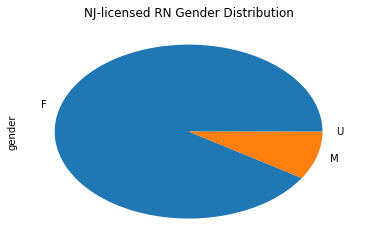

In [37]:
#Look at distribution of genders

df_clean['gender'].value_counts().plot(kind='pie')
plt.title('NJ-licensed RN Gender Distribution')

Text(0.5,1,'NJ-licensed RN Gender Distribution')

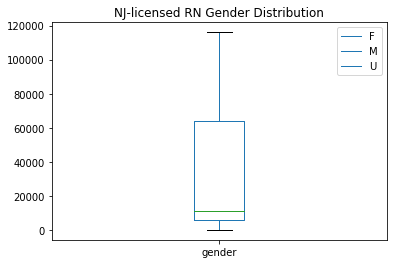

In [38]:
#A Different Look at distribution of genders

groups = df_clean.gender.unique().tolist()

df_clean['gender'].value_counts().plot(kind='box')
plt.legend(labels=groups)
plt.title('NJ-licensed RN Gender Distribution')

Unsurprisingly, we see that the RNs licensed in NJ are overwhelming Female, with a negligible number of them with 'Unknown' or unspecified genders.  We know that this number is not 0 from the gender value counts we viewed earlier, but the number does not show up on the graphs.

#### Expiration Date Distribution

Text(0.5,1,'License Expiration Counts by Year')

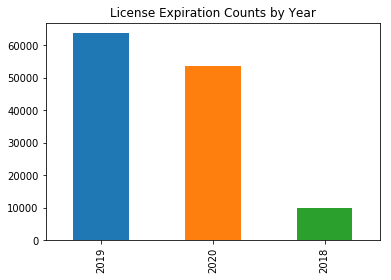

In [39]:
#Look at distribution of expiration dates by year

df_clean['expiration_date'].dt.year.value_counts().plot(kind='bar')
plt.title('License Expiration Counts by Year')

We see that we have more licenses in our data expiring in 2019, with less but a significant amount expiring in 2018. The difference between the number of expirations in 2019 and 2020 is less than 10,000; more specifically, there are just less than 20% more expirations in 2019 than in 2020. Only about 8% of the total NJ RN licenses expire in 2018. 

#### Experience Levels Distribution (in years) 

In [40]:
#Create a column to determine number of standardized experience years

def create_experience_col(df, issue_col='issue_date_std', now_yr = 2018):
    years = now_yr - df[issue_col].year
    return years

df_clean['experience'] = df_clean.apply(lambda df: create_experience_col(df), axis = 1)
df_clean.tail(10)

,full_name,first_name,middle_name,last_name,name_suffix,gender,license_no,issue_date,issue_date_notes,expiration_date,...,addr_zipcode,addr_county,addr_phone,addr_fax,addr_email,license_status_name,Unnamed: 19,issue_date_std,NJ_county,experience
127485,PATRICIA K HINDIN,Patricia,K,Hindin,NaN,F,26NO04670600,NaN,Unknown,2019-05-31,...,7030,HUDSON,2016561411,NaN,NaN,Active,NaN,1950-01-01,HUDSON,68
127486,PHYLLIS DELLA BELLA,Phyllis,NaN,Della Bella,NaN,F,26NR03989300,NaN,Unknown,2019-05-31,...,7727,MONMOUTH,7323604511,7329385960,pdb38@aol.com,Active,NaN,1950-01-01,MONMOUTH,68
127487,RAE BENNETT,RAE,NaN,BENNETT,NaN,F,26NO04176200,NaN,Unknown,2019-05-31,...,7052,ESSEX,9737316735,NaN,bennettrae@yahoo.com,Active,NaN,1950-01-01,ESSEX,68
127488,SHARON CHIECO,SHARON,NaN,CHIECO,NaN,F,26NO05406500,NaN,Unknown,2019-05-31,...,8724,OCEAN,7328364525,NaN,NaN,Active,NaN,1950-01-01,OCEAN,68
127489,SHERYL SIEGEL,Sheryl,NaN,Siegel,NaN,F,26NO04714700,NaN,Unknown,2020-05-31,...,7024,BERGEN,2019449117,NaN,sheryllsiegel@gmail.com,Active,NaN,1950-01-01,BERGEN,68
127490,SHIRLEY SMOYAK,SHIRLEY,NaN,SMOYAK,NaN,F,26NR01444400,NaN,Unknown,2018-05-31,...,88203208,MIDDLESEX,8489324727,7329326542,smoyak@docs.rutgers.edu,Active,NaN,1950-01-01,MIDDLESEX,68
127491,SUSAN BARNES,SUSAN,NaN,BARNES,NaN,F,26NO04279000,NaN,Unknown,2020-05-31,...,80558662,BURLINGTON,NaN,NaN,NaN,Active,NaN,1950-01-01,BURLINGTON,68
127492,SUSAN M DAVOLI,SUSAN,M,DAVOLI,NaN,F,26NO05429900,NaN,Unknown,2019-05-31,...,8242,CAPE MAY,6094084209,NaN,NaN,Active,NaN,1950-01-01,CAPE MAY,68
127493,SUSAN T CRISTELLI,SUSAN,T,CRISTELLI,NaN,F,26NO04729300,NaN,Unknown,2019-05-31,...,70542249,MORRIS,9733835600,9733831397,susan.cristelli@genesishcc.com,Active,NaN,1950-01-01,MORRIS,68
127494,VIRGINIA FERLISE,VIRGINIA,NaN,FERLISE,NaN,F,26NO05371500,NaN,Unknown,2020-05-31,...,189444122,BUCKS,2672617784,NaN,gingerrf@hotmail.com,Active,NaN,1950-01-01,UNKNOWN,68


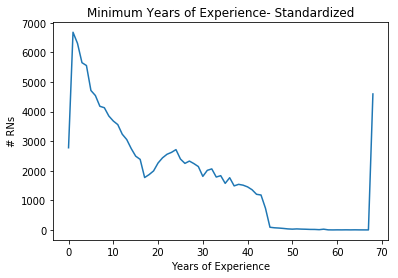

In [41]:
#Plot Distribution of Years of Experience

x = sorted(df_clean['experience'].unique().tolist())
y = df_clean.experience.value_counts()

s = pd.Series(y, index=x)
s.plot()
plt.xlabel('Years of Experience')
plt.ylabel("# RNs")
plt.title('Minimum Years of Experience- Standardized')
plt.show()

From the graph above, we see a trend that the number of actively licensed nurses decreases as we consider more years of experience, with a significantly high number of nurses who have either been practicing for more than about 66 years or whose tenure is unknown (since we standardized the data, imputing missing values with an issue date of January 1, 1950).  Based on the steady trend, we guess that this surprisingly high reported number of nurses with more than  of licensure 66 years is due to the standardization and not the actual fact.  On the other hand, this data could be more accurate than we think, considering the number of baby boomers who would possibly fit into this category. 

#### Home State Distribution

Text(0.5,1,'NJ-licensed RNs by State')

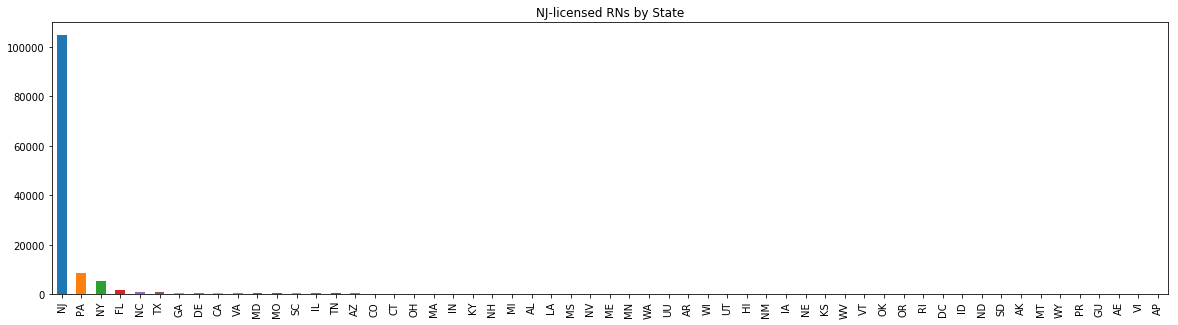

In [42]:
#Look at distribution of states

df_clean['addr_state'].value_counts().plot(kind='bar', figsize=(20, 5))
plt.title("NJ-licensed RNs by State")

Our bar chart indicates that most of the RNs licensed in NJ actually live in NJ, but a significant number live in Pennsylvania and New York which are close by, followed by Florida which is not.  We also see that there is a scattering of them representing many other states in the USA and other provinces or areas, which may be surprising. 

#### NJ County Distribution

Text(0.5,1,'RNs by NJ County')

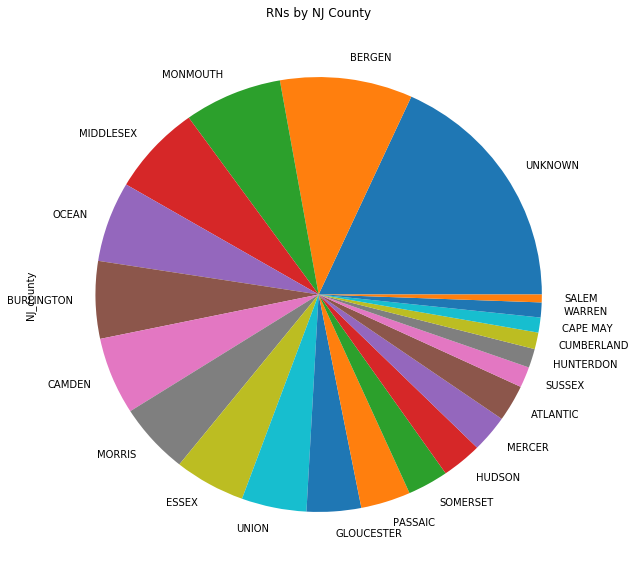

In [43]:
#Look at distribution of counties in NJ

df_clean['NJ_county'].value_counts().plot(kind='pie', figsize=(10, 10))
plt.title("RNs by NJ County")

The pie chart provides an interesting look at where the NJ-licensed RNs live across NJ or elsewhere.  We assume that the 'Unknown' category, accounting for approximately 18% or so, corresponds to those who live outside of NJ or whose county information was not provided. Further, excluding this group, we see that more nurses live in Bergen County than any other county, followed by a little more than half that amount in both Monmouth and Middlesex.  Salem has the least percentage of RNs calling it home.

#### Mapping County Distribution with Folium

Let's create a heat map containing the state of New Jersey using our folium package.  We'll use latitude and longitude coordinates of the center of the state from google maps to initialize our map and zoom in and out as necessary.  We also need to import some other packages for our tasks, specifically for getting our coordinates.

In [44]:
#Import Folium package needed for producing interactive maps

import folium
import requests
import json
from copy import copy

What we would like to do now is to map the distribution of RNs with home address in NJ by county.  For this, we will need the longitude and latitude coordinates for georgraphical boundary points of each county.  We can get this information from a github resource (a JSON file) online located at *https://raw.githubusercontent.com/python-visualization/folium/master/tests/us-counties.json* containing lots of information about every county in a state in the USA, grouped by state.  By reviewing the content, we determine that the 21 NJ county ID numbers are between 34001 and 34041, which will help us capture only this information and reducing our work, rather than going through the entire file of USA state counties.  The output of the code below (located with the help of Jason C. who the author thanks tremendously for his assistance) produces a dictionary we can use to access the 'id' numbers as a key to join information we have with county coordinates, etc. needed for graphing.

In [46]:
#Generate a dictionary consisting of the NJ county coordinates derived from information found online

url = 'https://raw.githubusercontent.com/python-visualization/folium/master/tests/us-counties.json'
resp = requests.get(url)
data = json.loads(resp.text)
# print(type(data))
# print(data.keys())

filtered = {}
filtered['type'] = 'FeatureCollection'
filtered['features'] = []
ids = (34001,34041)

def get_counties(data, output_dict, id_range=(1001,56045)):
    new_dict = copy(output_dict)
    features = data['features']
    for rec in features:
        idx = int(rec['id'])
        if idx >= id_range[0] and idx <= id_range[1]:
            new_dict['features'].append(rec)
    return new_dict

nj_county_geos = get_counties(data, filtered, id_range=ids)

In [47]:
nj_county_geos

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'id': '34001',
   'properties': {'name': 'Atlantic'},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-74.734949, 39.727779],
      [-74.417286, 39.557994],
      [-74.313224, 39.497748],
      [-74.548733, 39.295101],
      [-74.860918, 39.322485],
      [-74.986888, 39.514178],
      [-74.877349, 39.607286],
      [-74.734949, 39.727779]]]}},
  {'type': 'Feature',
   'id': '34003',
   'properties': {'name': 'Bergen'},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-74.21464, 41.135353],
      [-73.8915, 40.998429],
      [-73.918885, 40.916275],
      [-73.918885, 40.910798],
      [-73.935316, 40.883413],
      [-73.984608, 40.795782],
      [-74.011993, 40.823167],
      [-74.148916, 40.784829],
      [-74.132485, 40.81769],
      [-74.21464, 41.135353]]]}},
  {'type': 'Feature',
   'id': '34005',
   'properties': {'name': 'Burlington'},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-74

Now let's create a small dataframe with rows indexed by the NJ counties (excluding the 'UNKNOWN' values) and columns containing the county IDs found in the nj_county_geos dictionary and the RN count for those counties.

In [48]:
#Create dataframe with NJ county info to be used for folium mapping

def get_county_id(county_name, geo_dict=nj_county_geos):
    feature_records = geo_dict['features']
    id_found = None
    for rec in feature_records:
        county_id = rec['id']
        rec_name = rec['properties']['name']
        if county_name == rec_name.upper():
            id_found = copy(county_id)
            break
    return id_found

#Create counts column
counts = []
for row in NJ_addr_county:
    number = len(df_clean[df_clean['NJ_county'] == row])
    counts.append(number)
#print(counts)

col_dict = {'County': NJ_addr_county, 'Number': counts}
map_df = pd.DataFrame(col_dict)

In [49]:
map_df['ID'] = map_df['County'].apply(get_county_id)
map_df

,County,Number,ID
0,ATLANTIC,3454,34001
1,BERGEN,12235,34003
2,BURLINGTON,7329,34005
3,CAMDEN,7320,34007
4,CAPE MAY,1423,34009
5,CUMBERLAND,1573,34011
6,ESSEX,6563,34013
7,GLOUCESTER,5021,34015
8,HUDSON,3736,34017
9,HUNTERDON,1793,34019


Now we will draw the map of the US using folium and merging the geo dictionary we just imported with the map dataframe we created.

In [50]:
#Draw heat map of NJ to display RN density by county

map_df.drop(['County'], axis=1, inplace=True)

map_osm = folium.Map(location=[39.6901964,-74.8742036], zoom_start=8)

map_osm.choropleth(geo_data=nj_county_geos,
                   name='County Density Map',
                   data=map_df,
                   columns=['ID', 'Number'], 
                   key_on='feature.id', 
                   fill_color='YlGn',
                   fill_opacity=0.7,
                   line_opacity=0.2,
                   legend_name='RN Count'
                  )

folium.LayerControl().add_to(map_osm)


C:\Users\V\Anaconda3\lib\site-packages\folium\folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [51]:
map_osm

### Step 4: Analysis of EDA Results

Reflecting on what we discovered through EDA, we can make several inferences *about NJ* that would be supported by the data, motivating more investigation and certain considerations.  Some of the possibly obvious ones are:

#### *There are significantly more male RNs than females.* 

Should there be an increased effort to recruit more males in the industry?  How does this gender imbalance impact the nursing culture, employment or policy decisions that are made, or recruitment and retention efforts?



#### *There are significantly less RN licenses expiring in 2018* than there are in 2019 or 2020, which are are fairly proportionate to each other. 

Does this mean that less nurses licensed (including newly issued and renewals) two years prior renewed their licenses than than those newly licensed or did they already renew?  Is there a retention concern that needs attention and is this a trend?  Was there a difficulty in obtaining requirements for license renewal?  Will there be less or more funding needed in the budget to provide opportunities to obtain requirements for license renewal two years from now; will this group be added to those expiring in 2020?  



#### *There are signicantly more inexperienced NJ RNs than there are experienced ones, and with more experience comes higher probability of terminating practice in NJ*. 

Is this a retention crisis?  Why are RNs not maintaining long nursing careers in NJ? Will there be a shortage of mentors and those who can train new RNs?

#### *There are a number of NJ-licensed RNs living out of state.* 

Why are they not practicing in their home states if the location is signifantly far? Are these errors in the system?  Are they spending considerable money for job-related transportation?


#### *There is an imbalanced distribution of registered nurses residing across NJ counties, with the least in Salem*. 

Is the distribution proportionate to the population distribution among the counties, or would this present a problem in the event of a natural disaster where immediate medical support is needed in their residential areas?

As you can see, we now have many more questions than answers!  This is good, as productive research always produces more research problems  But these are good questions to ask those who are experts in the data, as often, the data scientist won't have as much of this expertise as the customer.  We discuss this a bit more in the next section. 

### Step 5: Presenting Results- Managing Expectation and Ethics

As data scientists, it is important to remember that we are usually not the Subject Matter Expert (SME) of the data; we should be experts at analyzing and garnering insight from the data.  Therefore, we must be very careful about drawing conclusions when sharing our results with the customers.  Doing the data analysis is just one step, although a major one, that should be taken during any decision-making process.  We want our customers to always be "data-informed" but very cautious about being "data-driven", as the data tells a story, but the story is almost always altered with the story *behind the data*.  The results we produced through EDA should be taken as insights and actually motivate further questions and investigations, that often can be explained with the SME's experience and hindsight.  So maybe instead of making recommendations to your customer on making decisions, make *comments* about what you observed and questions might be asked or examined. Explain the scope of your results, and always encourage your customer to gather other information to explain, support, or challenge the story that one might tell using the data. 

### A Word on Data Coarsening

Another consideration that data scientists should take is privacy.  When presenting data and insights gained from analyzing it, it is important to determine what information should be make public and which should be protected.  This particular data set has lots of Personally Identifiable Information (PII) which many people would not want shared if it were theirs.  An ethical data scientist always keeps this in mind, whether there are policies in place or not about sharing information, and has to decide what information is appropriate to present when discussing results, whether orally or in writing. 

In order to protect a user's PII but use it and/or present some data as part of the analysis process, we can implement ways to "coarsen" the data.  This process simply takes information and makes it more generalized by specific enough to do analysis.  In this data set, there were columns that can be used without others to coarsen the data itself.  For example, instead of providing one's full address, we can provide the city and state, the county and state, or some other information.  Let's look at the columns we now have in our data frame.  

In [52]:
df_clean.columns

Index(['full_name', 'first_name', 'middle_name', 'last_name', 'name_suffix',
       'gender', 'license_no', 'issue_date', 'issue_date_notes',
       'expiration_date', 'addr_line_1', 'addr_line_2', 'addr_city',
       'addr_state', 'addr_zipcode', 'addr_county', 'addr_phone', 'addr_fax',
       'addr_email', 'license_status_name', 'Unnamed: 19', 'issue_date_std',
       'NJ_county', 'experience'],
      dtype='object')

Again, when determining what information we need and what to present, we always need to keep in mind the task at hand- what questions are we trying to answer and what information will help be get those answers?  In this tutorial, we were concerned about the RN residence distribution across the state.  This means that we needed some location data, which could be sensitive, especially for safety.  We ended up using only some of the columns we were provided, namely the following:

- issue_date
- expiration_date
- addr_state
- addr_county

We also used the 'gender' column to look at the distribution.  We could have used the 'addr_city' column if we wanted to map out or plot specific locations across the state, which would have been nice to do, but the data was too messy to clean and unnecessary for this tutorial.  Additionally, although we did not use it explicity, we can use th 'license_no' column since it provides unique identifiers rather than using the actual names of the RNs included in the data set.  For our research topic, this information was unnecessary but it could become important to the customer if it wants to actually contact any of them in response to any actionable results of our analysis based on their home locations.  With that said, let's create a dataframe with only the columns that we used and created that could be used for presentation purposes when discussing our results with clients and their stakeholders (or anyone else). We'll also order the columns in a useful way.

In [53]:
#Present only certain columns of the data frame, in a particular order

column_order = ['license_no', 'issue_date_std', 'issue_date_notes', 'expiration_date', 
                'experience', 'gender', 'addr_state', 'NJ_county']

df_coarse = df_clean[column_order]
df_coarse

,license_no,issue_date_std,issue_date_notes,expiration_date,experience,gender,addr_state,NJ_county
0,26NR03881300,1950-01-01,Standardized,2018-05-31,68,F,NJ,MERCER
1,26NR03410300,1950-01-01,Standardized,2020-05-31,68,F,NJ,SOMERSET
2,26NR02374200,1950-01-01,Standardized,2020-05-31,68,F,NJ,MIDDLESEX
3,26NR03652100,1950-01-01,Standardized,2018-05-31,68,F,NJ,MIDDLESEX
4,26NR03060900,1950-01-01,Standardized,2020-05-31,68,F,NJ,BERGEN
5,26NR02848500,1950-01-01,Standardized,2018-05-31,68,F,NJ,GLOUCESTER
6,26NR02716300,1950-01-01,Standardized,2020-05-31,68,F,ME,UNKNOWN
7,26NR03568700,1950-01-01,Standardized,2020-05-31,68,F,NJ,MONMOUTH
8,26NR02246000,1950-01-01,Standardized,2020-05-31,68,F,NJ,SOMERSET
9,26NR02308700,1950-01-01,Standardized,2018-05-31,68,F,NJ,MIDDLESEX


Now that's a nice looking, clean dataframe with some useful information!

## DONE!